In [1]:
import torch as th
from active_critic.learner.active_critic_learner import ActiveCriticLearner, ACLScores
from active_critic.learner.active_critic_args import ActiveCriticLearnerArgs
from active_critic.policy.active_critic_policy import ActiveCriticPolicy
from active_critic.utils.gym_utils import make_dummy_vec_env, make_vec_env, parse_sampled_transitions, sample_expert_transitions, DummyExtractor, new_epoch_reach, sample_new_episode
from active_critic.utils.pytorch_utils import make_part_obs_data, count_parameters
from active_critic.utils.dataset import DatasetAC
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from active_critic.utils.dataset import DatasetAC
from active_critic.model_src.whole_sequence_model import (
    WholeSequenceModelSetup, WholeSequenceModel, CriticSequenceModel)
from active_critic.model_src.transformer import (
    ModelSetup, generate_square_subsequent_mask)
from active_critic.policy.active_critic_policy import ActiveCriticPolicySetup, ActiveCriticPolicy
import argparse
from prettytable import PrettyTable

from gym import Env
th.manual_seed(0)




def make_wsm_setup(seq_len, d_output, device='cuda'):
    wsm = WholeSequenceModelSetup()
    wsm.model_setup = ModelSetup()
    seq_len = seq_len
    d_output = d_output
    wsm.model_setup.d_output = d_output
    wsm.model_setup.nhead = 8
    wsm.model_setup.d_hid = 200
    wsm.model_setup.d_model = 200
    wsm.model_setup.nlayers = 5
    wsm.model_setup.seq_len = seq_len
    wsm.model_setup.dropout = 0.2
    wsm.lr = 1e-4
    wsm.model_setup.device = device
    wsm.optimizer_class = th.optim.AdamW
    wsm.optimizer_kwargs = {}
    return wsm



def make_acps(seq_len, extractor, new_epoch, device, batch_size=32):
    acps = ActiveCriticPolicySetup()
    acps.device = device
    acps.epoch_len = seq_len
    acps.extractor = extractor
    acps.new_epoch = new_epoch
    acps.opt_steps = 5
    acps.optimisation_threshold = 1
    acps.inference_opt_lr = 5e-3
    acps.inference_opt_lr = 1e-2
    
    acps.optimize = True
    acps.batch_size = 32
    acps.stop_opt = False
    acps.clip = False
    return acps


def setup_ac(seq_len, num_cpu, device, tag):
    env, expert = make_vec_env(tag, num_cpu, seq_len=seq_len)
    d_output = env.action_space.shape[0]
    wsm_actor_setup = make_wsm_setup(
        seq_len=seq_len, d_output=d_output, device=device)
    wsm_critic_setup = make_wsm_setup(
        seq_len=seq_len, d_output=1, device=device)
    acps = make_acps(
        seq_len=seq_len, extractor=DummyExtractor(), new_epoch=new_epoch_reach, device=device)
    actor = WholeSequenceModel(wsm_actor_setup)
    critic = CriticSequenceModel(wsm_critic_setup)
    ac = ActiveCriticPolicy(observation_space=env.observation_space, action_space=env.action_space,
                            actor=actor, critic=critic, acps=acps)
    return ac, acps, env, expert


def make_acl(device, logname,  seq_len , imitation_phase, total_training_epsiodes, training_episodes, min_critic_threshold):
    device = device
    acla = ActiveCriticLearnerArgs()
    acla.data_path = '/data/bing/hendrik/EvalAC_Fast'
    acla.device = device
    acla.extractor = DummyExtractor()
    acla.imitation_phase = imitation_phase
    tag = 'pickplace'
    acla.logname = tag + logname
    acla.tboard = True
    acla.batch_size = 16
    number = 10
    acla.val_every = 20000
    acla.add_data_every = 20000
    acla.validation_episodes = 25 #(*8)
    acla.validation_rep = 8
    acla.training_epsiodes = training_episodes
    acla.actor_threshold = 1e-2
    acla.critic_threshold = 1e-2
    acla.min_critic_threshold = min_critic_threshold
    acla.num_cpu = 25
    acla.patients = 40000
    acla.total_training_epsiodes = total_training_epsiodes
    acla.start_critic = False

    epsiodes = 30
    ac, acps, env, expert = setup_ac(seq_len=seq_len, num_cpu=min(acla.num_cpu, acla.training_epsiodes), device=device, tag=tag)
    eval_env, expert = make_vec_env(tag, num_cpu=acla.num_cpu, seq_len=seq_len)
    acl = ActiveCriticLearner(ac_policy=ac, env=env, eval_env=eval_env, network_args_obj=acla)
    return acl, env, expert, seq_len, epsiodes, device

/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-30 13:53:24.436721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn

Sampling transitions. 18


/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/metaworld/policies/policy.py:41: UserWarning: Constant(s) may be too high. Environments clip response to [-1, 1]
  warnings.warn('Constant(s) may be too high. Environments clip response to [-1, 1]')
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/

last rewards: 1.0
last success: 1.0
self.last_scores: None


/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn

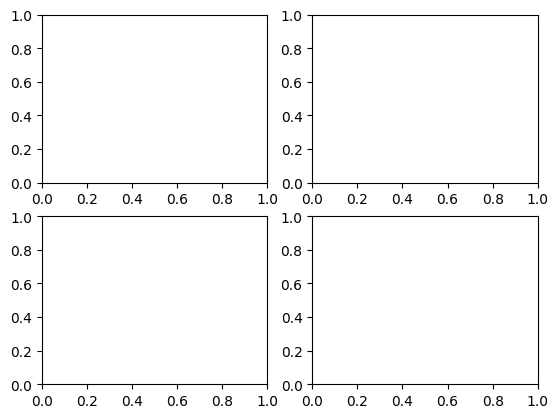

/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


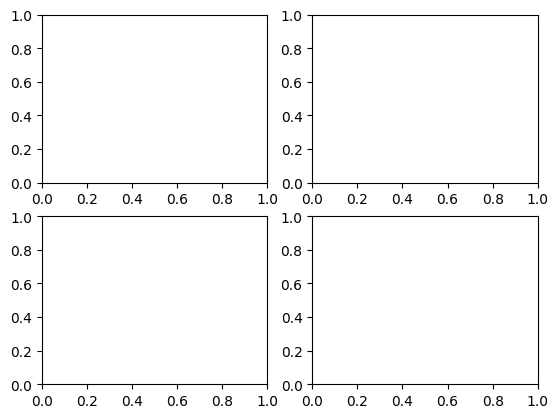

In [2]:
seq_len = 100
demos = 18
training_episodes = 10
min_critic_threshold = 5e-5
logname = f'seq_len: {seq_len}, demonstrations: {demos}, training_episodes: {training_episodes}, min critic: {min_critic_threshold} Incline BC'
device = 'cuda'
imitation_phase = True
total_training_epsiodes = 200
acl, env, expert, seq_len, epsiodes, device = make_acl(
                            device, seq_len=seq_len, 
                            logname=logname, 
                            imitation_phase=imitation_phase, 
                            total_training_epsiodes=total_training_epsiodes,
                            training_episodes=training_episodes,
                            min_critic_threshold=min_critic_threshold)
acl.network_args.num_expert_demos = demos
acl.add_training_data(policy=expert, episodes=demos, seq_len=seq_len)

In [3]:
acl.train(epochs=10000000)

/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


_____________________________________________________________
Sampling transitions. 25


/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn

Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Success Rate: 0.0 optimize
Reward: 0.0 optimize
training samples: 18 optimize
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Success Rate: 0.0
Reward: 0.0
training samples: 18
self.get_num_training_samples(): 0
self.network_args.total_training_epsiodes: 200
_____________________________________________________________
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
/data/bing/hendrik/EvalAC_Fast/pickplaceseq_len: 100, demonstrations: 18, training_episodes: 10, min critic: 5e-05 Incline BC/best_validation
Success Ra

KeyboardInterrupt: 

In [ ]:
acl.run_validation(optimize=False)

Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Sampling transitions. 25
Success Rate: 0.41999998688697815
Reward: 0.41999998688697815
training samples: 18


In [ ]:
equal_state_dict(acl.policy, other_policy)

NameError: name 'equal_state_dict' is not defined

In [ ]:
import copy

In [ ]:
th.save(acl.policy, 'test')

In [ ]:
other_policy = th.load('test')

In [ ]:
def equal_state_dict(model1, model2):
    for p1, p2 in zip(model1.parameters(), model2.parameters()):
        if p1.data.ne(p2.data).sum() > 0:
            return False
    return True

In [ ]:
acl.policy.critic.init_model()

In [ ]:
equal_state_dict(acl.policy, other_policy)